# Seer Technical Interview: EEG Seizure Clasficiation using 1D CNN
This project uses the **BONN EEG Dataset** to train a **1D convolution neural network (CNN)** to distinguish **seizure (ictal) vs non seizure (interictal/healthy) EEG segments**. 
The Bonn dataset contains EEG recordings from healthy volunteers and epilepsy patients, with segments labeled as seizure (ictal) or non-seizure (comprised of interictal and healthy). The goal is to demonstrate a deep learning approach for seizure detection from single-channel EEG data.


### Dataset

**Bonn EEG dataset** contains **five sets (A–E)**, each with 100 single-channel EEG segments (~23.6 seconds each, 4097 samples per segment, 173.61 Hz sampling rate).  

| Set | Description | Seizure? |
|-----|------------|-----------|
| A   | Healthy, eyes open | No |
| B   | Healthy, eyes closed | No |
| C   | Interictal, non-epileptogenic | No |
| D   | Interictal, epileptogenic | No |
| E   | Seizure (ictal) | Yes |


### Challenges and limitations of BONN dataset
**Small dataset**: Relatively small dataset, with only 500 segments, 400 which are non-seizure and 100 which are seizure. To address this issue, model architecture is optimised to minimise potential overfitting and data augmentation is implemented. 

**Class imbalance**: Class imbalance with 4:1 non-seizure to seizure ratio. To address this issue during training, class weights are used and data augmentation of seizure segments.  

**No patient-level data**: BONN dataset has flat datasets containing healthy, interictal and seizure data. Therefore, we do not know which segments came from same patients, therefore training segments may have same patients as validation segments. This may result in over-optimistic performance metrics.
### Goals

1. Load and preprocess EEG segments from all sets
2. Normalize and filter EEG signals
3. Build and train a MLP to classify seizure vs non-seizure segments as a baseline comparison model
4. Build and train a **1D CNN** to classify seizure vs non-seizure segments
5. Evaluate model performance using loss curves, accuracy and confusion matrix
6. Apply data augmentation to address potential overfitting and limited sample size


### Links:
- [Bonn EEG Dataset](https://www.upf.edu/web/ntsa/downloads/-/asset_publisher/xvT6E4pczrBw/content/2001-indications-of-nonlinear-deterministic-and-finite-dimensional-structures-in-time-series-of-brain-electrical-activity-dependence-on-recording-regi)
- [Original Paper: Andrzejak et al., 2001](https://www.upf.edu/documents/229517819/232450661/Andrzejak-PhysicalReviewE2001.pdf/0e9a54b8-8993-b400-743e-4d64fa29fb63)


In [189]:
## Import and load packages
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import importlib
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, balanced_accuracy_score
from scipy.signal import butter, filtfilt


sys.path.append(os.path.abspath(".."))
import scripts
# import my functions
from scripts.preprocess import normalise_segments
from scripts.utils import plot_eeg_segment
from scripts.preprocess import load_and_preprocess
from scripts.train import train
from scripts.train import evaluate
from scripts.models import simple_EEG_MLP
from scripts.models import simple_EEG_CNN


## Load and Preprocess Data

**Filtering:** Butterworth filter to remove high frequency noise above 40 Hz
- Attenuates frquencies beyond cutoff of 40 Hz (e.g. may be caused by muscle artifacts, powerline noise), preserving key EEG rhythms without ripples


In [211]:
## Load and preprocess data
base_path = os.path.abspath("../data")

# 0:non-seizure, 1: seizure 
folders = {
    #"A": 0,
    #"B": 0,
    "C": 0,
    "D": 0, 
    "E": 1
}

X, y = load_and_preprocess(base_path, folders)
X = np.array(X) 
print("EEG segments shape:", X.shape)
y = np.array(y)
print("Labels shape:", y.shape)

EEG segments shape: (300, 4097)
Labels shape: (300,)


## Visualise EEG segments

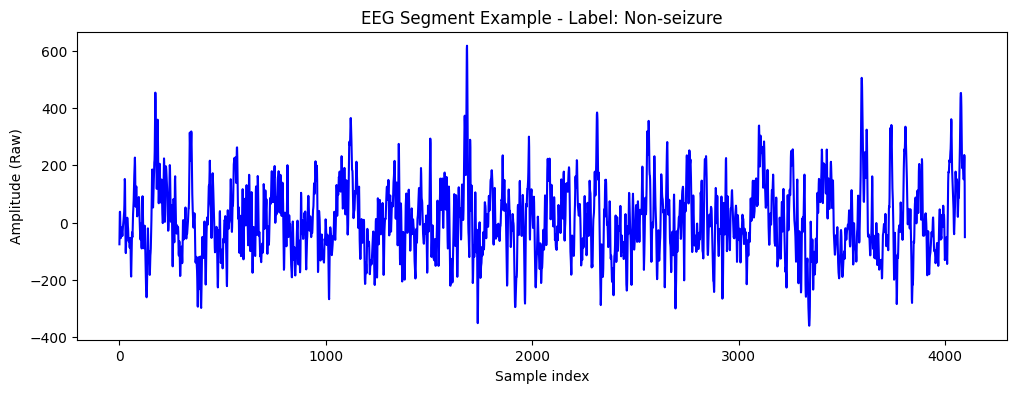

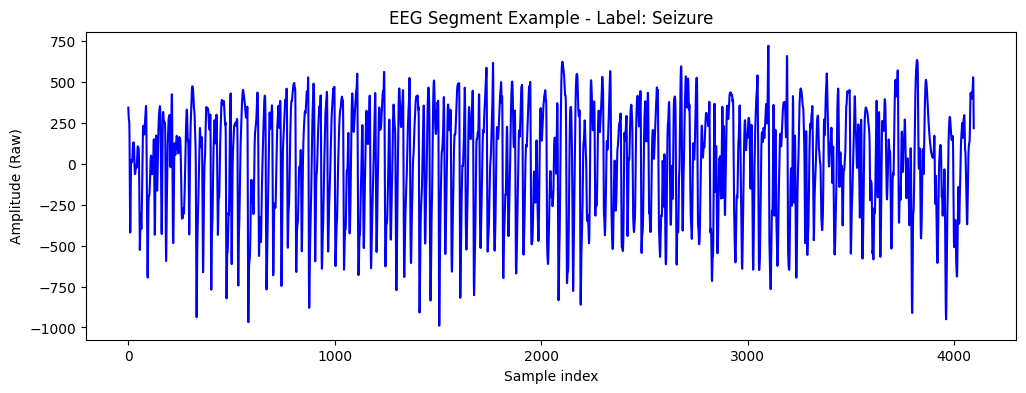

In [212]:
# Visualise example of non-seizure 
segment = X[0]  
label = y[0]    
plot_eeg_segment(segment, label, num_samples = 4097, norm= False)


# Visualise example of seizure 
segment = X[-1] 
label = y[-1]    
plot_eeg_segment(segment, label, num_samples = 4097, norm= False)

## Simple Multi-Layer Perceptron: Baseline Model
**Overview:**
The Multi-Layer Perceptron (MLP) is a fully connected neural network where each input feature is connected to every neuron in the next layer. For EEG classification, the MLP treats the signal as a flat vector of values, without explicitly considering the order or temporal relationships of the data points.

**Pros:**
- Simple architecture: easy to implement and train
- Baseline performance: provides reference point to compare more complex CNN models
- Fewer hyperparameters

**Cons:**
- Ignores temporal structures: doesn't consider the local patterns of EEG
- Overfitting risk: fully connected layers can have many parameters relative to number of samples

**Motivation:**
By first training an MLP model, we can measure how much improvement is gained by 1D CNN models, which can detect temporal patterns and allows us to test pre-processing, training and evaluation pipelines on a simpler model before advancing to more complex models. 


In [224]:
# X: shape (500, 4097), y: labels (0/1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=7, stratify=y
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Normalise data
X_train_normalised, X_test_normalised = normalise_segments(X_train, X_test)

Train shape: (210, 4097)
Test shape: (90, 4097)


In [225]:
# Convert NumPy arrays to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) # (n_samples, 4097)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_ds = TensorDataset(X_train_torch, y_train_torch)
test_ds = TensorDataset(X_test_torch, y_test_torch)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

print(f"Train tensor shape: {X_train_torch.shape}")  # Should print: torch.Size([350, 1, 4097])
print(f"Test tensor shape: {X_test_torch.shape}") 

Train tensor shape: torch.Size([210, 1, 4097])
Test tensor shape: torch.Size([90, 1, 4097])


In [237]:
class simple_EEG_MLP(nn.Module):
    def __init__(self, input_length=4097):
        super(simple_EEG_MLP, self).__init__()

        self.fc1 = nn.Linear(input_length, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        x = x.view(x.size(0), -1)

        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = self.fc4(x)
        return x


Epoch 1/25 | Train Loss: 0.8717, Train Acc: 0.5905 | Val Loss: 0.6897, Val Acc: 0.7222
Epoch 2/25 | Train Loss: 0.6580, Train Acc: 0.7190 | Val Loss: 0.6226, Val Acc: 0.8333
Epoch 3/25 | Train Loss: 0.6013, Train Acc: 0.7952 | Val Loss: 0.5686, Val Acc: 0.8556
Epoch 4/25 | Train Loss: 0.5373, Train Acc: 0.8048 | Val Loss: 0.5189, Val Acc: 0.8444
Epoch 5/25 | Train Loss: 0.4582, Train Acc: 0.8381 | Val Loss: 0.4824, Val Acc: 0.8111
Epoch 6/25 | Train Loss: 0.4235, Train Acc: 0.8619 | Val Loss: 0.4610, Val Acc: 0.7778
Epoch 7/25 | Train Loss: 0.3921, Train Acc: 0.8524 | Val Loss: 0.4461, Val Acc: 0.7778
Epoch 8/25 | Train Loss: 0.3272, Train Acc: 0.9143 | Val Loss: 0.4352, Val Acc: 0.7778
Epoch 9/25 | Train Loss: 0.3168, Train Acc: 0.9143 | Val Loss: 0.4277, Val Acc: 0.7778
Epoch 10/25 | Train Loss: 0.2851, Train Acc: 0.9333 | Val Loss: 0.4199, Val Acc: 0.7778
Epoch 11/25 | Train Loss: 0.2693, Train Acc: 0.9190 | Val Loss: 0.4125, Val Acc: 0.7889
Epoch 12/25 | Train Loss: 0.2356, Train A

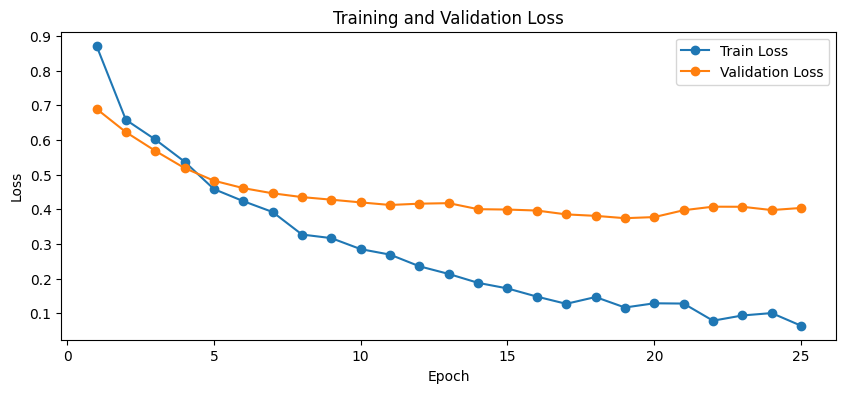

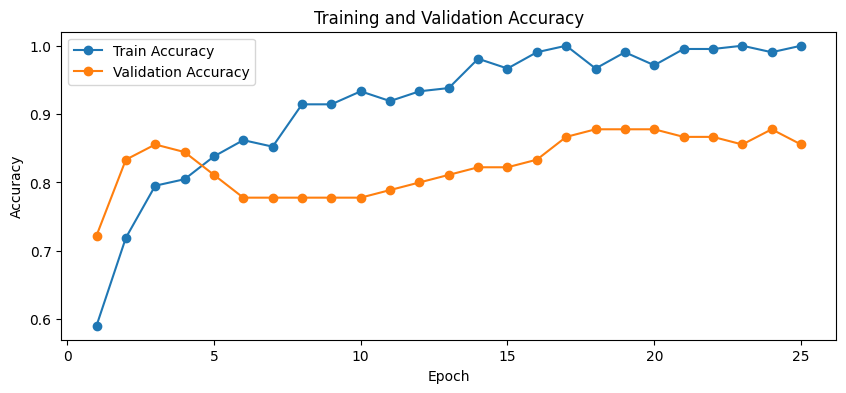

In [239]:
from scripts.utils import plot_training_history
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = simple_EEG_MLP().to(device)
class_weights = torch.tensor([0.5, 1.0], dtype=torch.float)  # seizures get double weight
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) # define optimisation algorithm

epochs = 25 # train the model for 25 full passes

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# train and evaluate each epoch
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, epochs=None)

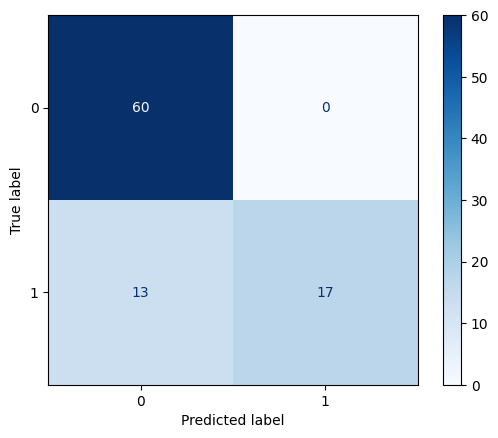

In [240]:
model.eval()  # set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)              # raw logits
        preds = torch.argmax(outputs, dim=1)  # predicted class
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# concatenate all batches
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues')


### Simple MLP Model Summary 
The simple MLP model served as a baseline model for EEG classification, treating each segment as a flattened vector thus ignoring temporal structure of EEG. Training over 25 epochs, we can see that the MLP model quickly dropped loss and increased accuracy in training set, but showed signs of overfitting, with valdiation loss and accuracy being significantly worse. Based on the confusion matrix we can see that it is struggling with false negative (T2 error), which indicates that clinically, this would not be a good seizure detection model. 

This model serves as a useful reference, with subsequent CNN models focused on learning temporal structures of EEG. 


##  1D Convolutional Neural Network

### Overview
The 1D CNN applies convolutional filters along the temporal dimension of EEG signals.  
For EEG classification, it treats input as a **sequence of time samples**, allowing the model to learn local temporal patterns.

### Key components:
- **Convolutional layers:** Extract hierarchical features from raw signals  
- **Pooling layers:** Reduce temporal resolution while preserving key features  
- **Batch normalization:** Stabilizes training  
- **Dropout:** Prevents overfitting  
- **Fully connected layers:** Perform final binary classification  

### ✅ Pros
- Automatically learns temporal patterns without manual feature engineering  
- Faster and computationally efficient compared to recurrent networks (e.g., LSTMs)  
- Well suited for time series classification  

### ❌ Cons
- Multiple hyperparameters to tune (filter sizes, channels, pooling strategies)  
- Requires sufficient training data to learn robust features  

### 🎯 Motivation
1D CNNs capture temporal dynamics and patterns characteristic of seizure events while being computationally efficient for real-time applications.


### First trained a basic model: no data augmentation or hyperparameter tuning:

**Model Architecture:**
- Input: 1D time-series EEG signal (4097 samples)
- Architecture: Multi-layer 1D CNN with batch normalization and dropout
- Output: Binary classification (seizure vs non-seizure)
- Regularization: Dropout layers, L2 weight decay, batch normalization
- Loss function: CrossEntropyLoss with class weights to handle imbalance

**Training Strategy:**
- Validation method: 5-fold stratified cross-validation
- Optimizer: Adam with learning rate 1e-3
- Class weighting: Applied to loss function to address 1:4 class imbalance
- Early stopping: Implemented with patience=5 to prevent overfitting
- Normalization: Z-score normalization per fold (using training statistics only)

In [213]:
## 1D CNN Model

class simple_EEG_CNN(nn.Module):
    def __init__(self, input_length=4097, dropout= 0.5):
        super(simple_EEG_CNN, self).__init__()

        # Conv1: Capture seizure spike patterns (70-200ms)
        # Kernel=25 → ~145ms at 173Hz
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=25, stride=1, padding=12) 
        self.bn1 = nn.BatchNorm1d(16) # BatchNorm after conv1
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.dropout1 = nn.Dropout(dropout * 0.6)
        # After conv1+pool1: (batch, 16, 1024)

        # Conv2: Capture medium-term patterns (300-500ms)
        # Kernel=15 → ~350ms in the pooled space
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=15, stride=1, padding=7)
        self.bn2 = nn.BatchNorm1d(32) # BatchNorm after conv2
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.dropout2 = nn.Dropout(dropout * 0.8)  
        # After conv3+pool3: (batch, 32, 256)

        # Conv3: Capture long-term evolution patterns
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=3)
        self.bn3 = nn.BatchNorm1d(64) # BatchNorm after conv3
        self.pool3 = nn.MaxPool1d(kernel_size=4, stride=4)
        # after conv 3 (batch, 64, 64)
        
        # Dropout for regularization
        self.dropout3 = nn.Dropout(dropout)

        # global pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(64, 64)  
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
            
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)  
        
        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)  
        
        # Conv block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.dropout3(x)  
        
        # Global pooling and classifier
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        
        return x


In [214]:
importlib.reload(scripts.CV)
from scripts.CV import train_with_kfold_cv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fold_results = train_with_kfold_cv(
    X, 
    y, 
    simple_EEG_CNN,
    n_splits=5, 
    max_epochs=25, 
    batch_size=32, 
    device=device,
    patience= 5,
    min_delta= 0.001,
    model_kwargs={'input_length': 4097}
)

Starting 5-Fold Cross-Validation

FOLD 1/5
------------------------------------------------------------
  Epoch 10/25 | Train: 0.1072/0.9667 | Val: 0.2369/0.9333 | Patience: 4/5
  Early stopping at epoch 11
  Fold 1 Summary:
    Best Val Acc: 0.9000 at epoch 6
    Total epochs: 11

FOLD 2/5
------------------------------------------------------------
  Epoch 10/25 | Train: 0.1146/0.9667 | Val: 0.1880/0.9333 | Patience: 1/5
  Epoch 20/25 | Train: 0.0847/0.9750 | Val: 0.1070/0.9500 | Patience: 5/5
  Early stopping at epoch 20
  Fold 2 Summary:
    Best Val Acc: 0.9667 at epoch 15
    Total epochs: 20

FOLD 3/5
------------------------------------------------------------
  Epoch 10/25 | Train: 0.1575/0.9583 | Val: 0.3364/0.8667 | Patience: 2/5
  Early stopping at epoch 13
  Fold 3 Summary:
    Best Val Acc: 0.9167 at epoch 8
    Total epochs: 13

FOLD 4/5
------------------------------------------------------------
  Epoch 10/25 | Train: 0.1151/0.9708 | Val: 0.2288/0.9167 | Patience: 3/5


### Evaluating Results

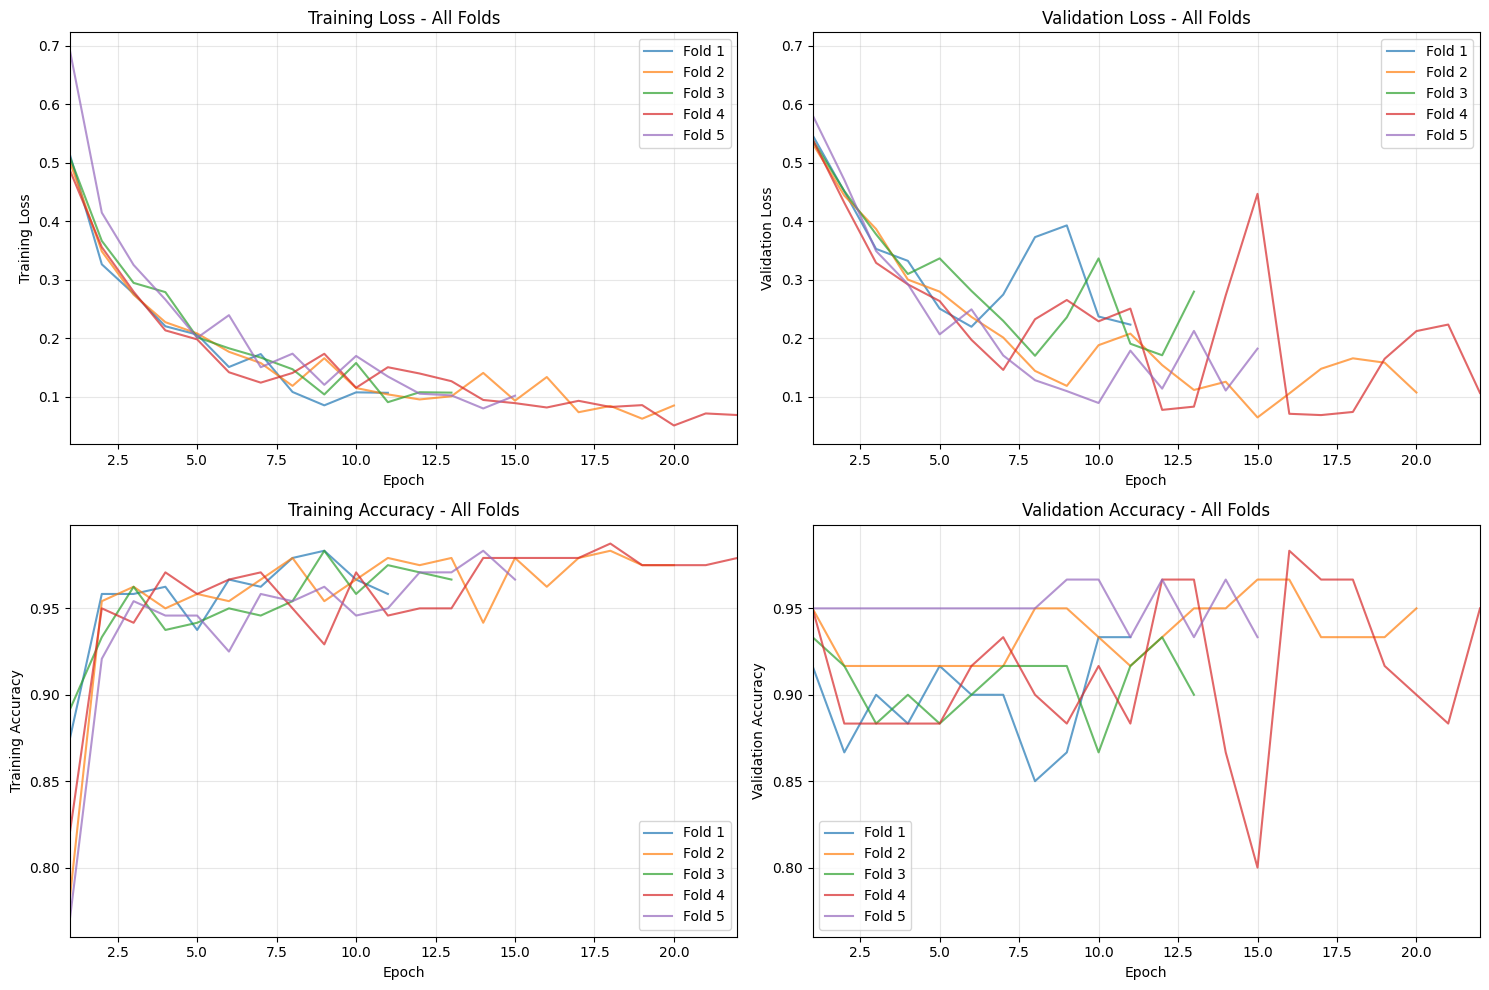

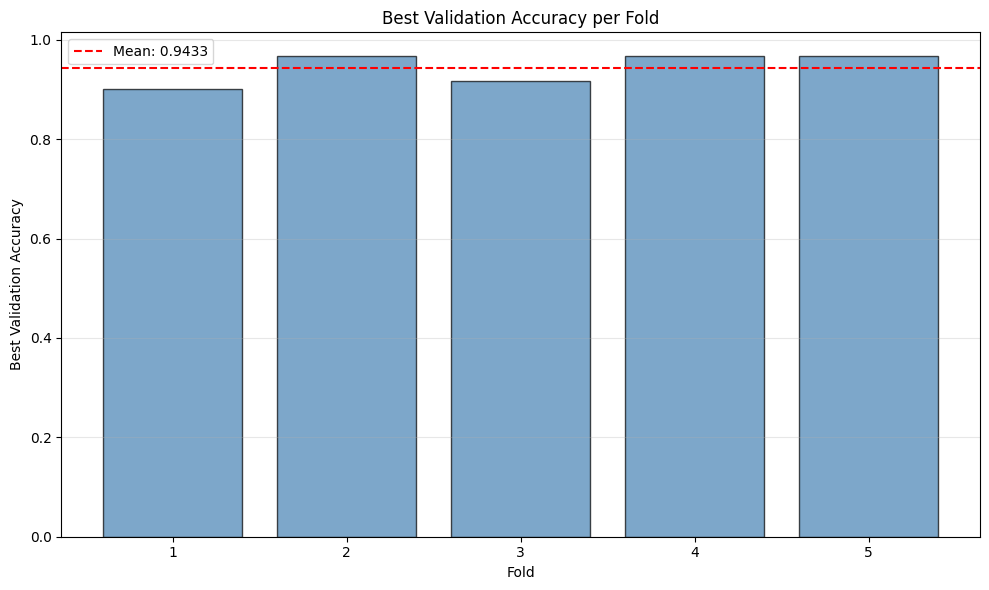

Mean accuracy: 0.9433
Std accuracy: 0.0291
Best fold: 2
Best accuracy: 0.9667


In [215]:
importlib.reload(scripts.utils)
from scripts.utils import plot_kfold_results
plot_kfold_results(fold_results, 5)

print(f"Mean accuracy: {np.mean(fold_results['best_val_accs']):.4f}")
print(f"Std accuracy: {np.std(fold_results['best_val_accs']):.4f}")


best_fold_idx = np.argmax(fold_results['best_val_accs'])
print(f"Best fold: {best_fold_idx + 1}")
print(f"Best accuracy: {fold_results['best_val_accs'][best_fold_idx]:.4f}")

Calculating metrics from saved models...

Fold 1: Acc=0.9000 | Bal_Acc=0.8732 | F1=0.8500 | Prec=0.9444 | Rec=0.7727
Fold 2: Acc=0.9667 | Bal_Acc=0.9556 | F1=0.9333 | Prec=0.9333 | Rec=0.9333
Fold 3: Acc=0.9167 | Bal_Acc=0.8611 | F1=0.8387 | Prec=1.0000 | Rec=0.7222
Fold 4: Acc=0.9667 | Bal_Acc=0.9697 | F1=0.9643 | Prec=0.9310 | Rec=1.0000
Fold 5: Acc=0.9667 | Bal_Acc=0.9444 | F1=0.9412 | Prec=1.0000 | Rec=0.8889

KEY METRICS SUMMARY

Metric               Mean ± Std           Range               
------------------------------------------------------------
Accuracy             0.9433 ± 0.0291     [0.9000, 0.9667]
Balanced Accuracy    0.9208 ± 0.0447     [0.8611, 0.9697]
F1 Score             0.9055 ± 0.0511     [0.8387, 0.9643]
Precision            0.9618 ± 0.0315     [0.9310, 1.0000]
Recall (Sensitivity) 0.8634 ± 0.1023     [0.7222, 1.0000]

Average Confusion Matrix:
  TN (Non-Seizure correct): 39.2
  FP (False alarm):         0.8
  FN (Missed seizure):      2.6  ⚠️ Most critical!
  TP

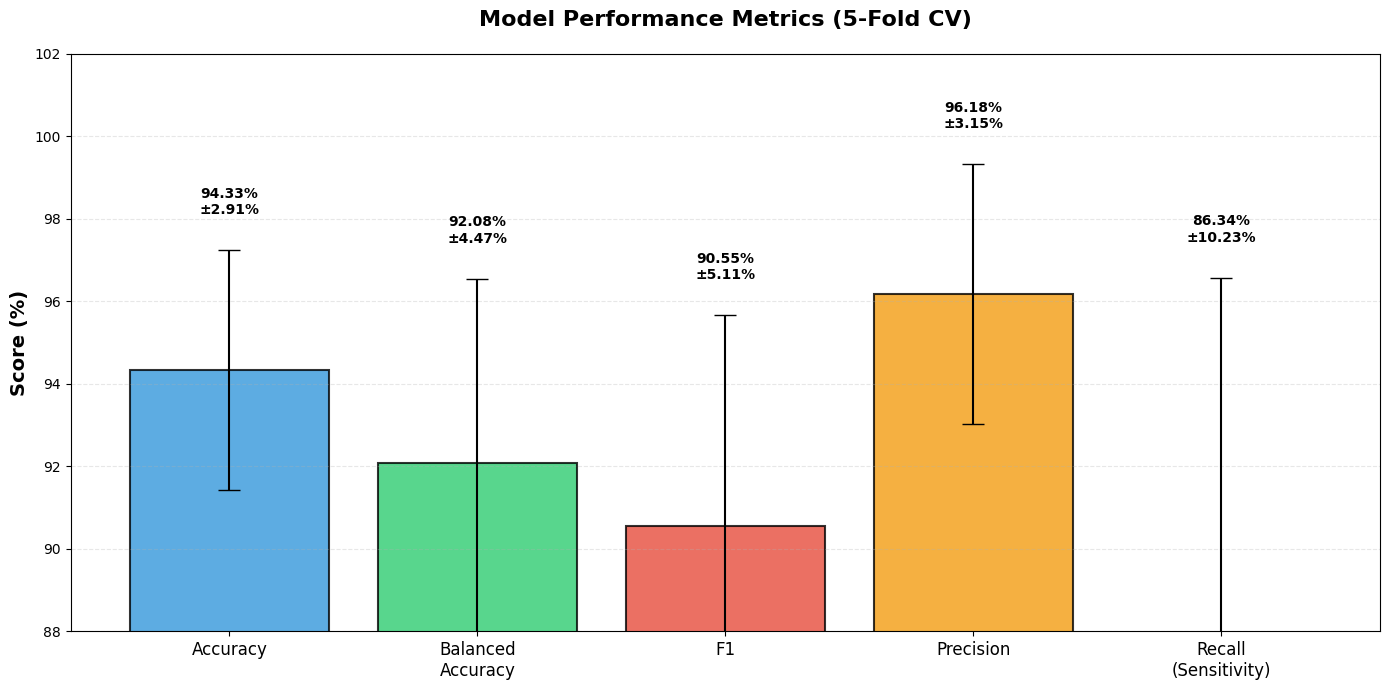

In [216]:
importlib.reload(scripts.CV)
from scripts.CV import calculate_metrics_from_saved_models, print_quick_summary, plot_metrics_comparison        
# Calculate comprehensive metrics
metrics = calculate_metrics_from_saved_models(X, y, simple_EEG_CNN, n_splits=5, device= device)
print_quick_summary(metrics)
plot_metrics_comparison(metrics)

### First model writeup

- Seeing high performance metrics: may be indicative of overlapping patients and overoptimistic?
- Seeing variability in validation loss and accuracy compared to training: may be indicative of overfitting
- Next steps: add data-augmentation, improve generalisability of model

## Second 1D CNN Model: Data Augmentation and Hyperparameter tuning

- What is data augmentation?
- Why is it useful?
- How will I implement

In [243]:
def augment_eeg_signal(signal, aug_type):
    """
    Augment a single EEG signal 
    """
    if aug_type == 'noise':
        noise_level = 0.05 * np.std(signal)
        noise = np.random.normal(0, noise_level, signal.shape)
        return signal + noise
    
    elif aug_type == 'scale':
        scale_factor = np.random.uniform(0.85, 1.15)
        return signal * scale_factor
    
    elif aug_type == 'shift':
        shift = np.random.randint(-100, 100)
        return np.roll(signal, shift)
    
    elif aug_type == 'warp':
        warp_factor = np.random.uniform(*(0.98, 1.02))
        orig_indices = np.arange(len(signal))
        new_indices = np.linspace(0, len(signal)-1, int(len(signal) * warp_factor))
        f = interp1d(new_indices, signal, kind='linear', fill_value='extrapolate')
        return f(orig_indices)
    
    else:
        return signal

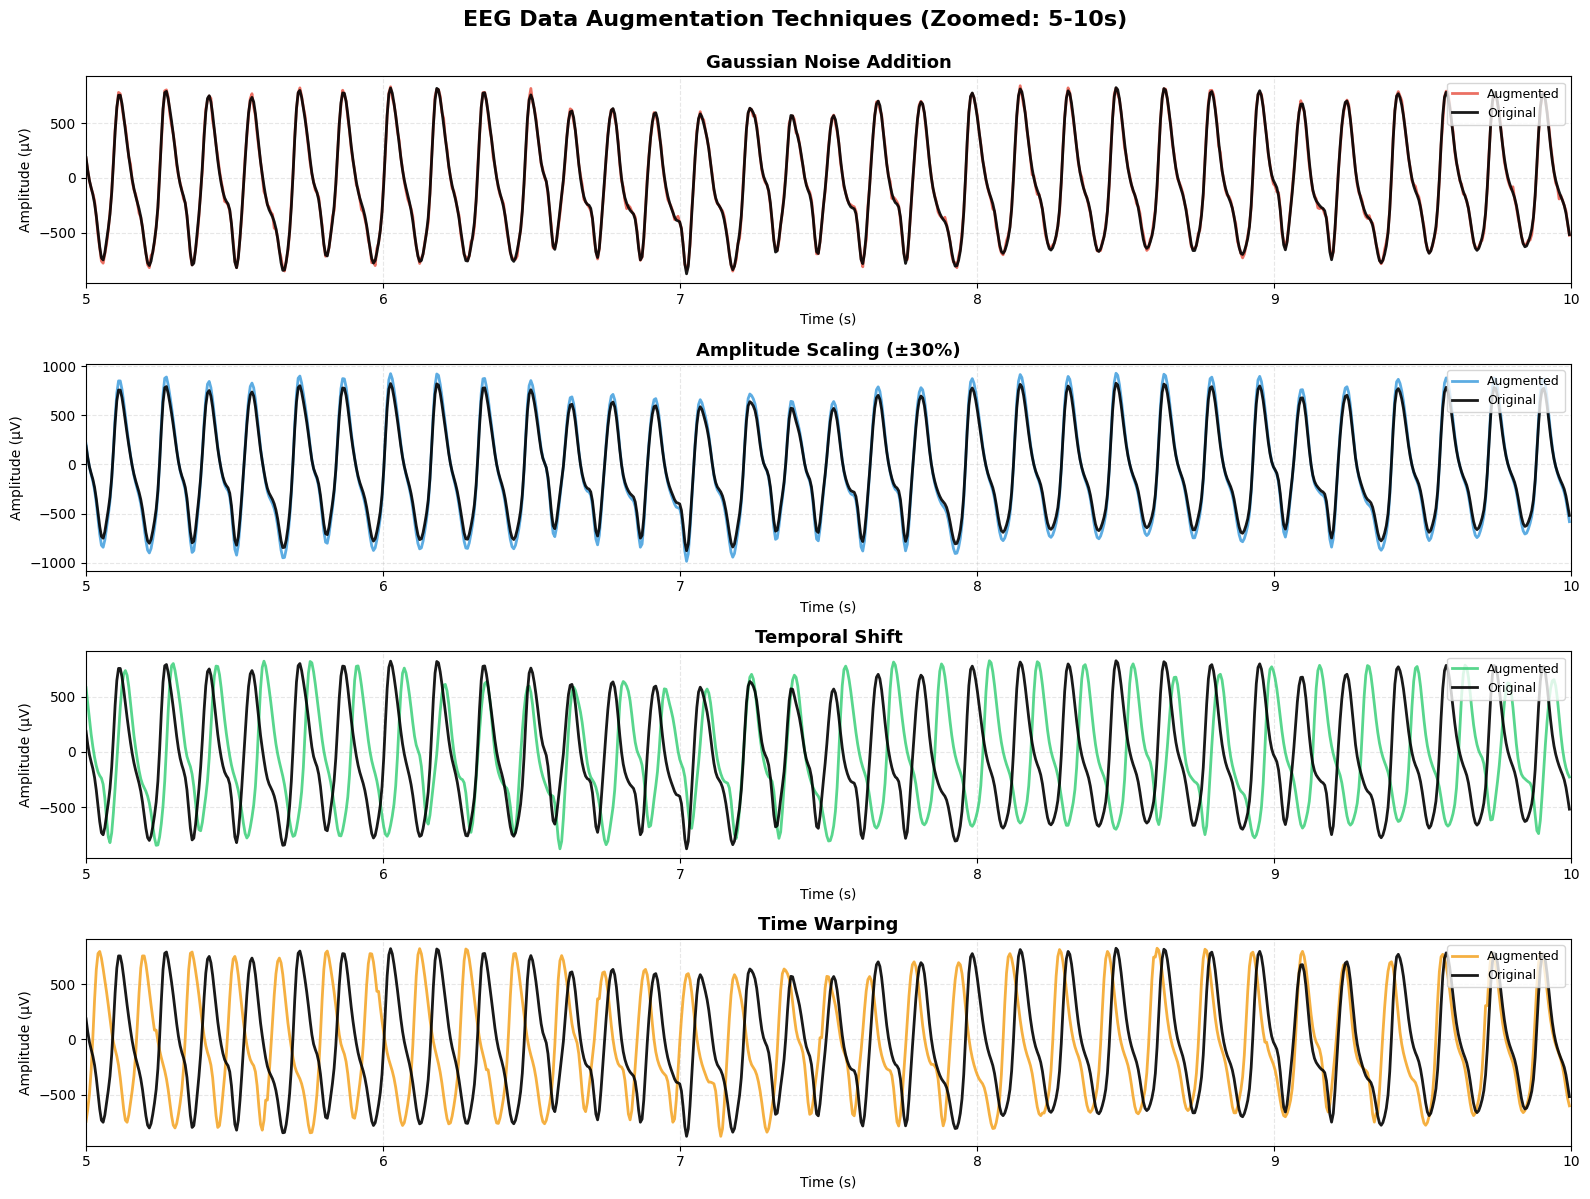

In [244]:
visualize_augmentation_comparison(X_seizure, sample_idx=0)

In [245]:
importlib.reload(scripts.augmentation)

from scripts.augmentation import train_with_kfold_cv_augmented
cv_results_with_aug = train_with_kfold_cv_augmented(
    X, y,
    model_class=simple_EEG_CNN,
    n_splits=5,
    max_epochs=50,
    batch_size=32,
    device=device,
    use_augmentation=True,  # Use augmentation
    aug_methods=['noise', 'scale', 'shift', 'warp'],
    tune_hyperparams= True, n_tuning_trials = 3
)


Starting 5-Fold Cross-Validation
Using NESTED CV with hyperparameter tuning (3 trials/fold)
Using augmentation: ['noise', 'scale', 'shift', 'warp']

FOLD 1/5
------------------------------------------------------------
  Tuning hyperparameters (3 random trials)...
    Trial 1/3: LR=1e-03, BS=16, Dropout=0.40, WD=1e-05 → Val Acc: 1.0000
    Trial 2/3: LR=1e-03, BS=32, Dropout=0.50, WD=1e-04 → Val Acc: 1.0000
    Trial 3/3: LR=5e-04, BS=16, Dropout=0.40, WD=1e-05 → Val Acc: 0.9375
  → Best params: LR=1e-03, BS=16, Dropout=0.40, WD=1e-05 (Tuning Val Acc: 1.0000)
  Before augmentation: 78 seizures, 162 non-seizures
Original seizure samples: 78
Generating 72 augmented samples...
Final augmented seizure count: 150
  After augmentation: 150 seizures, 162 non-seizures
  Epoch 10/50 | Train: 0.1236/0.9615 | Val: 0.1782/0.9333 | Patience: 2/5
  Early stopping at epoch 18
  Fold 1 Summary:
    Best Val Acc: 0.9500 at epoch 13
    Total epochs: 18

FOLD 2/5
----------------------------------------

Calculating metrics from saved models...

Fold 1: Acc=0.9333 | Bal_Acc=0.9282 | F1=0.9091 | Prec=0.9091 | Rec=0.9091
Fold 2: Acc=0.9833 | Bal_Acc=0.9889 | F1=0.9677 | Prec=0.9375 | Rec=1.0000
Fold 3: Acc=0.9833 | Bal_Acc=0.9722 | F1=0.9714 | Prec=1.0000 | Rec=0.9444
Fold 4: Acc=0.9667 | Bal_Acc=0.9697 | F1=0.9643 | Prec=0.9310 | Rec=1.0000
Fold 5: Acc=1.0000 | Bal_Acc=1.0000 | F1=1.0000 | Prec=1.0000 | Rec=1.0000

KEY METRICS SUMMARY

Metric               Mean ± Std           Range               
------------------------------------------------------------
Accuracy             0.9733 ± 0.0226     [0.9333, 1.0000]
Balanced Accuracy    0.9718 ± 0.0245     [0.9282, 1.0000]
F1 Score             0.9625 ± 0.0296     [0.9091, 1.0000]
Precision            0.9555 ± 0.0375     [0.9091, 1.0000]
Recall (Sensitivity) 0.9707 ± 0.0376     [0.9091, 1.0000]

Average Confusion Matrix:
  TN (Non-Seizure correct): 39.0
  FP (False alarm):         1.0
  FN (Missed seizure):      0.6  ⚠️ Most critical!
  TP

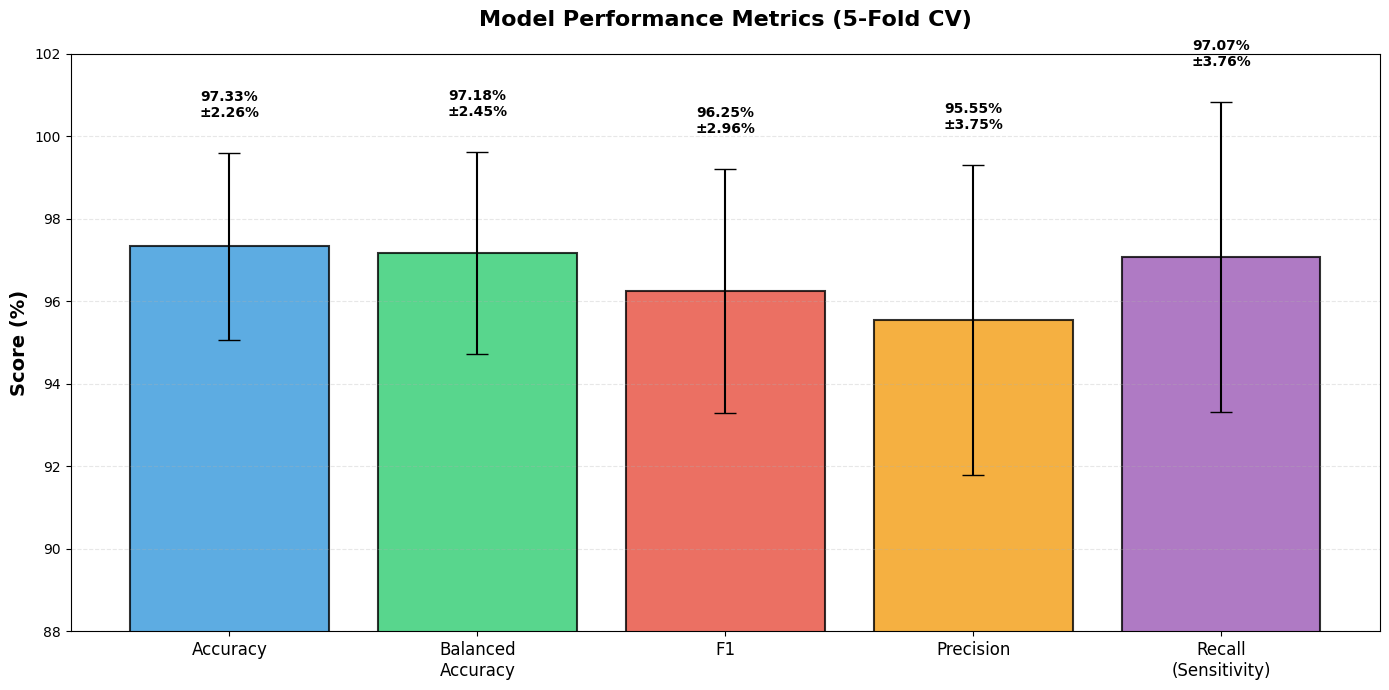

In [246]:
# Calculate metrics
metrics_with_aug = calculate_metrics_from_saved_models(
    X, y, simple_EEG_CNN, n_splits=5, device=device
)
print_quick_summary(metrics_with_aug)
plot_metrics_comparison(metrics_with_aug)


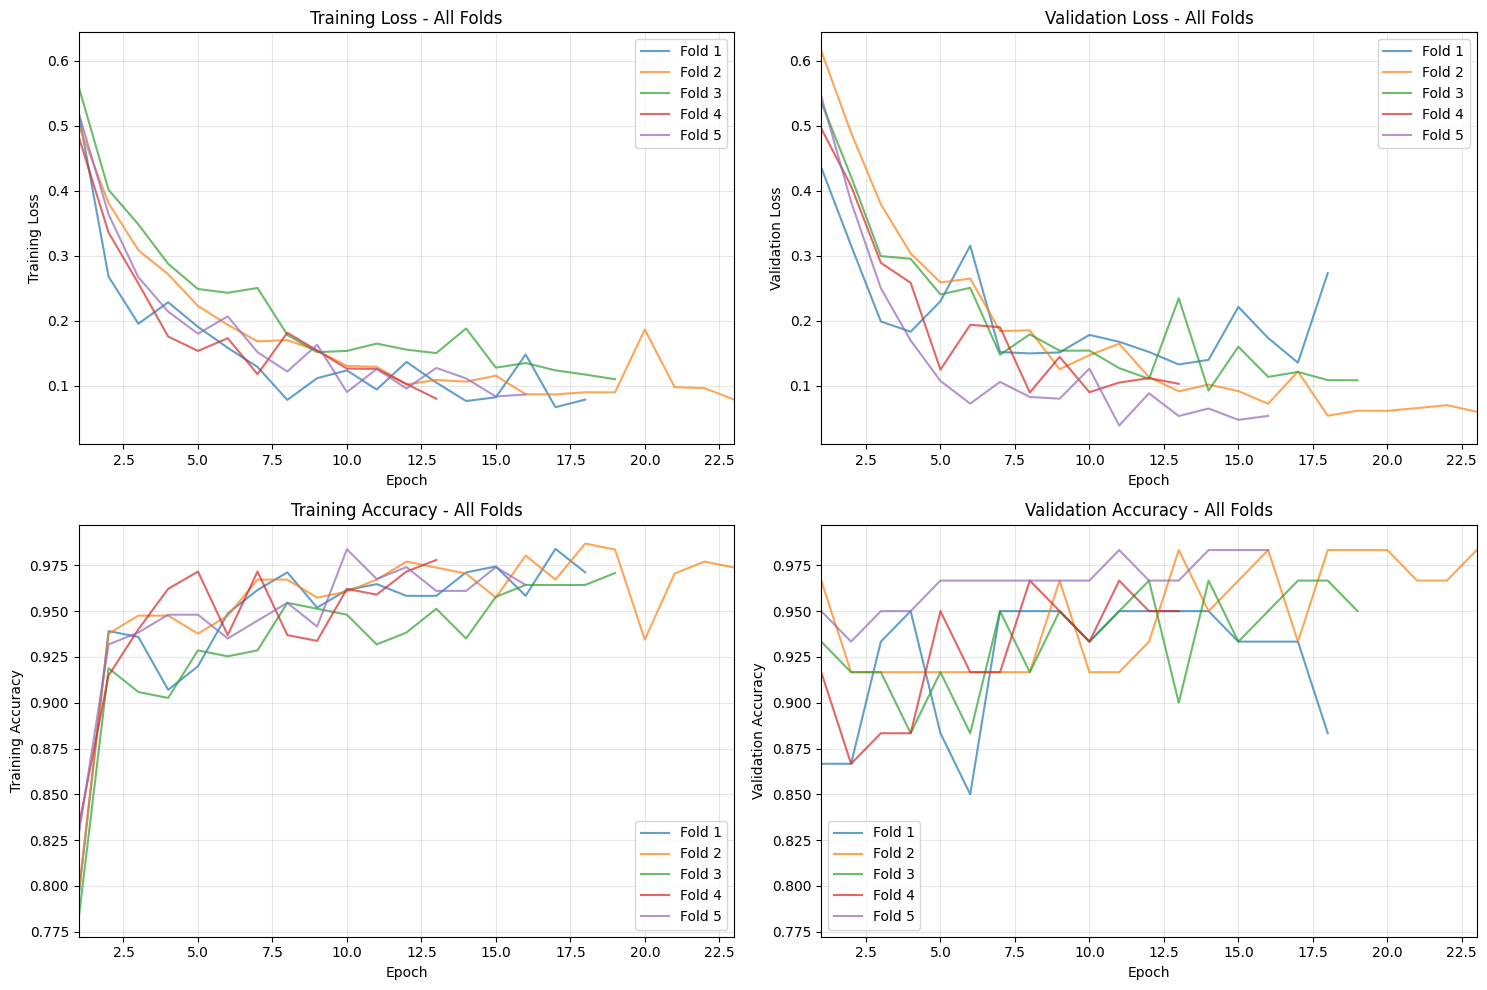

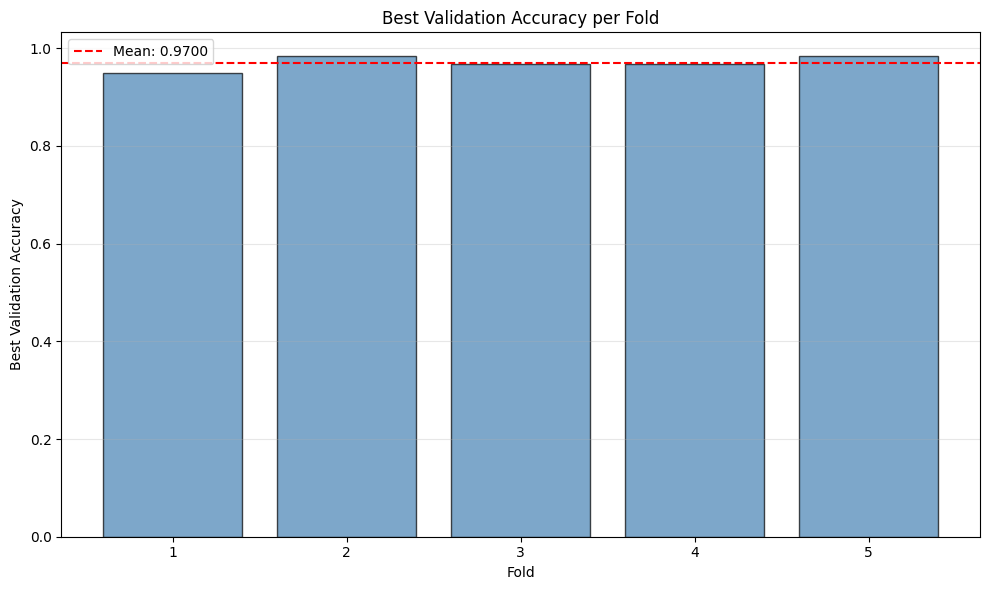

Mean accuracy: 0.9700
Std accuracy: 0.0125
Best fold: 2
Best accuracy: 0.9833


In [247]:
importlib.reload(scripts.utils)
from scripts.utils import plot_kfold_results
plot_kfold_results(cv_results_with_aug , 5)

print(f"Mean accuracy: {np.mean(cv_results_with_aug ['best_val_accs']):.4f}")
print(f"Std accuracy: {np.std(cv_results_with_aug ['best_val_accs']):.4f}")

# 6. Get best fold
best_fold_idx = np.argmax(cv_results_with_aug ['best_val_accs'])
print(f"Best fold: {best_fold_idx + 1}")
print(f"Best accuracy: {cv_results_with_aug ['best_val_accs'][best_fold_idx]:.4f}")

## Limitations and Future Directions

1. **Limited patient-level metadata**

The BONN dataset does not include patient identifiers, so the same individual may appear in both the training and validation splits. This can inflate performance estimates and limits the ability to assess true generalisation to unseen patients.

2. **Need for external validation**

To properly evaluate real-world generalisability, the model should be tested on an independent dataset containing different subjects and recording conditions. This would demonstrate whether the learned features transfer beyond the BONN data.
However, incorporating an external dataset introduces additional considerations:
Preprocessing differences (e.g., filtering, artefact removal)
Channel selection or averaging to match configurations
Resampling to align sampling frequencies
Potential differences in hardware, noise profiles, and clinical conditions


3. **Potential improvement via transfer learning**

A practical next step is to pretrain the CNN on the BONN dataset, freeze early convolutional layers, and fine-tune on a second dataset. This approach reduces training time, leverages learned low-level EEG features, and provides a more realistic estimate of how the model might perform in cross-dataset or clinical deployment scenarios.